In [1]:
# import necessary libraries
import re, string, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score


SEED=42

/var/folders/hv/xq_dj8v97_j03qt43slpb1q80000gn/T/ipykernel_90100/3983995195.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

In [3]:
# cargar los datos
df_original = pd.read_csv('data/tipo1_entrenamiento_estudiantes.csv')

# Entendimiento

In [4]:
df_original.shape

(7875, 2)

In [111]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [5]:

df_original.sample(5)

,Review,Class
7302,El hotel se nota que esta recién renovado en concepto de negocios y cuenta con un magnifico centro de negocios abierto en el Lobby. Los cuartos están muy amplios y al tarifa es relación precio calidad muy buena.,5
2328,"Bien ubicado aunque no está en el centro ya que se encuentra a una cuadra de Montejo, habitaciones tranquilas y agradables, restaurante con buenos buffetes tematicos, la piscina sin ser muy grande de buen tamaño",4
690,"Lo mejor de La Nacional, es que pidas lo que pidas todo esta muy rico. El ambiente es muy agradable tanto para ir de negocios, con familia o en pareja. \nHay que reservar ya que es fácil que se llene. \nLa carta es una buena...Más",5
4802,Un servicio de transporte seguro y eficaz para llegar a las laderas de Medellin. Todo muy limpio y ordenado,5
1380,"Es el peor hotel que he visto, viejo, sucio, se cae a trozos, tiene más de 20 plantas , con cuatro ascensores , y solo funciona uno en ocasiones, la mayor parte del tiempo está averiado. La piscina la utilizan para el publico en general, con latas tiradas por todos los lados, sucia, gente bañándose vestidos, comiendo y fumando en el agua. Para olvidar. cucarachas como tortugas.",1


In [57]:
df_stats = df_original.copy()
df_stats['Word_Count'] = df_stats['Review'].apply(lambda x: len(x.split()))
df_stats

,Review,Class,Word_Count
0,"Nos alojamos en una casa alquilada en la ciudad amurallada. Parecía tan segura como cualquier otra gran ciudad con un montón de buenos restaurantes, tiendas y vida nocturna. Gran lugar para un grupo con intereses variados, no estoy seguro de que le traiga a los niños aquí sólo porque no hay mucho que hacer para ellos. Asegúrate de aventurarse fuera de la ciudad, pero algunos también es un gran lugar para alojarse",4,72
1,"La comida está bien, pero nada especial. Yo tenía mejor comida Mexcan en los Estados Unidos. Las margaritas eran geniales. El Mahi Mahi pescado recocido y seco. La carne fajitas aceptable y el coco camarones sabroso. El tortilla chips aperitivo fue decepcionante.",3,42
2,"En mi opinión, no es una como muchos usuarios reclaman. Es un gran paladar que parece ser una parada con muchos grupos de excursión. El menú es más interesante que los otros restaurantes comimos en. La parte más interesante de la experiencia es que el...edificio está en una sección de La Habana Centro. Las plantas inferiores están muy deteriorados, y tienen apartamentos donde viven muchos trabajadores de restaurante. Los pisos superiores, donde el restaurante es, han sido restauradas a gloria pasada. Las reservas son imprescindibles. Plan de 40 a 50 CUC por persona para una comida con cócteles y vinos.Más",3,100
3,"esta curiosa forma que asemeja una silla de montar de ahi su nombre es el icono de la ciudad, vale mucho la pena si no puedes ubir lo puedes asdnirr de cualquier punto de la ciudad",4,36
4,Lo mejor era la limonada. Me gusto la comida de todo el mundo y era sosa y un poco frío.,2,20
...,...,...,...
7870,"El motivo de mi estancia fue porque vine a un congreso medico, y me hospedaron en este lugar, las instalaciones están bien sin ser excelentes, la habitación bien pero tardaban casi todo el día en llegar a hacer el aseo y arreglar el cuarto, la verdad siempre quedaba un poco sucio, la regadera tenía tapado el desagüe por lo que se hacía una alberca, los alimentos buenos (rescatable el pan que acompañan con café) Lo que si es muy bueno es la gente que trabaja en el hotel, son súper amables y serviciales. Este hotel es una buena opción para su estancia además que está a 3 cuadras de paseo Montejo. Saludos desde acá 😀",3,115
7871,"Es difícil revisar el castillo porque apenas podíamos caminar por el sofocante calor, pero no creo que puedas apreciar completamente este lugar a menos que tenía un guía o eran un historiador. De lo contrario, es un gran montículo de cemento con algunos espeluznante, oscuros túneles dentro. Nada es realmente marcados o explicó excepto por una pequeña tienda de regalos y una sala de información que incluye un extraño, uniforme de viejo y sucio, montada en un soldado Mannequen sin cabeza, así que puedes llevar tu imagen. fuimos porque no hay mucho más que hacer, pero definitivamente no es la vida cambia.",3,102
7872,"Si vas a Mérida no puedes perderte de este lugar y que tiene una nueva sucursal más amplia y con la misma calidad, excelente servicio y comida deliciosa y bien servida.",5,31
7873,"Este imperdible sitio, que lleva el nombre del conquistador, es una joya urbana.Su amplitud para el tráfico local motorizado evita congestionamietos, a ambos lados una amplia zona para corredores o simples caminadores llena de pequeños cafés, restaurantes y bares para todos los gustos. Me impresionó la limpieza, la tranquilidad que en nuestros días es un privilegio y AUSENCIA DE GRAFITI. qUE HERMOSURA ES IMPERDIBLE.",5,64


In [58]:
word_count_stats = df_stats['Word_Count'].describe()
word_count_stats

count    7875.000000
mean       70.889778
std        76.289629
min         6.000000
25%        34.000000
50%        45.000000
75%        87.000000
max      2495.000000
Name: Word_Count, dtype: float64

In [6]:
df_original.isnull().sum()

Review    0
Class     0
dtype: int64

No hay registros nulos, los datos son completos.

<Axes: xlabel='Class'>

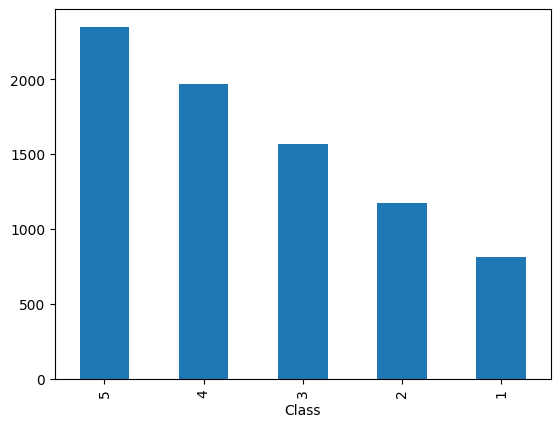

In [7]:
# distribución de variable objetivo
df_original['Class'].value_counts().plot(kind='bar')

Todos los valores de la columna 'Class' son válidos.

In [8]:
df_original.duplicated().sum()

71

Hay 71 registro duplicados, estos se deben eliminar del dataset.

In [9]:
duplicated_rows = df_original[df_original.duplicated()]
duplicated_rows


,Review,Class
518,"La ubicación es muy buena, al igual que la vista, la playa contrario a lo que esperaba resultó que estaba bastante limpia.\nSe percibe el sabor y la frescura en los insumos de los alimentos , lo cual es parte de la experiencia que ofrece...el lugar ya que tienen sus propias granjas productoras. La carta es limitada ( lo cual en mi caso prefiero, ya que se nota el esmero en cada uno de los platos que preparan), los precios están por arriba del promedio de otros restaurantes cercanos pero no llegan a ser exagerados, desconozco si eso se debió a que solo se tenía un salón disponible, ya que en la fecha que lo visité, el resto del restaurante se encontraba en remodelación (es la único razón por lo cual no otorgo la evaluación más alta), mi sugerencia sería que siguieran manteniendo los precios ya que los hace muy competitivos … sin duda regresaría, es un lugar que debes visitar en Veracruz sobre todo si eres fanático del buen comer…Más",4
1112,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
1605,"Cierran a las 3 pm, cobraron $85 adultos y niños (por lo menos los de 2 años) y adulto mayor gratis. A la entrada hay guías. Se juntan grupos de mínimo 10 personas y te cobran $70 por persona o $700 a quien se los pague. Excelente explicación y atención de parte de ellos. Poca claridad de información en redes, y el número telefónico no sirve. Llegamos fácilmente con waze. Lleven buen bloqueador, sombrero y de preferencia tenis.",3
1843,"Acudimos un sábado 2 de julio a las 11:15 de la mañana. Estuvimos esperando más de media hora nosotros dos y otro grupo de cuatro personas fuera, porque la camarera estaba dentro. Nos vio como estábamos esperando y no fue capaz de salir a atendernos...o dar alguna explicación si el bar estaba abierto o cerrado.\n\nNos tuvimos que marcharMás",1
1851,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
...,...,...
7520,"Un lugar muy limpio ordenado hermoso con áreas amplias que vale la pena disfrutar en familia un momento, primera vez que lo visito pero vale la pena acudir.",3
7601,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
7756,Deben de actualizar los horarios en las diferentes páginas ya que como yo o cualquiera de los visitantes que vamos podemos llegar y encontrar cerrado y luego la página para buscar información no funciona.,3
7794,"Wow Había escuchado muchas recomendaciones de este lugar, pero nunca había ido, hace unos fui y me precio muy interesante toda las historias que hay en este museo.",5


# Procesamiento y Preparación

In [10]:
# eliminar las filas duplicadas
df_prep = df_original.drop_duplicates()

In [11]:
df_prep.shape

(7804, 2)

In [12]:
# TODO: balancear las clases (variable objetivo)

## Divisón en entrenamiento y prueba 

In [118]:
X_train, X_test, y_train, y_test = train_test_split(df_prep["Review"], df_prep["Class"], test_size = 0.3, stratify = df_prep["Class"], random_state = SEED)

In [119]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5462,), (2342,), (5462,), (2342,))

## Tokenización / Vectorización

"Feature engineering"

* Bag of Words / Count Tokenizer
* Tf-IDF

In [120]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/mci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [121]:
stop_words = set(stopwords.words('spanish'))

In [122]:
def tokenize_text(text):
    # convertir a minúsculas
    text = text.lower()
    
    # eliminar caracteres numericos
    text = re.sub(r'\d+', '', text) 

    # eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # eliminar caracters especiales
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons TODO: not all emojis included here
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')  
     
    tokens = word_tokenize(text)

    # eliminar los stems de las palabras
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

In [123]:
bow_vectorizer = CountVectorizer(stop_words=list(stop_words), tokenizer=tokenize_text)
tfidf_vectorizer = TfidfVectorizer( stop_words=list(stop_words), tokenizer=tokenize_text)

In [124]:
X_train_bow = bow_vectorizer.fit_transform(X_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estareis', 'estari', 'estariais', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'estuvier', 'estuvies', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habeis', 'habi', 'habiais', 'habr', 'habreis', 'habri', 'habriais', 'hast', 'hayais', 'hem', 'hub', 'hubier', 'hubies', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'sereis', 'seri', 'seriais', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambi', 'ta

In [125]:
len(bow_vectorizer.vocabulary_)

12574

In [126]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [127]:
len(tfidf_vectorizer.vocabulary_)

12574

In [128]:
df_bow_sklearn = pd.DataFrame(X_train_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())
df_bow_sklearn

,...,......,8,aa,aaaah,ab,abad,abaj,abajol,abajom,...,zonassi,zoo,zoofari,zoolog,zorr,zotan,zuegly,zul,zum,zumb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5458,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
with open('columns_bow.txt', 'w') as f:
    for item in bow_vectorizer.get_feature_names_out():
        f.write("%s\n" % item)

In [130]:
df_tfid_sklearn = pd.DataFrame(X_train_tfidf.toarray(),columns=tfidf_vectorizer.get_feature_names_out())
df_tfid_sklearn

,...,......,8,aa,aaaah,ab,abad,abaj,abajol,abajom,...,zonassi,zoo,zoofari,zoolog,zorr,zotan,zuegly,zul,zum,zumb
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.075208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5458,0.078237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5459,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5460,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


# Entrenamiento y evaluación de modelos

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## Naive Bayes

Desarrollado por: Maria Castro Iregui

[descripción]

In [131]:
from datetime import datetime
current_time = datetime.now().strftime("%H:%M:%S")
print("Current time:", current_time)


Current time: 11:02:37


In [132]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_bow, y_train)


MultinomialNB()

In [133]:
feature_importances = np.exp(naive_bayes.feature_log_prob_)[1,:] - np.exp(naive_bayes.feature_log_prob_)[0,:]

<Axes: >

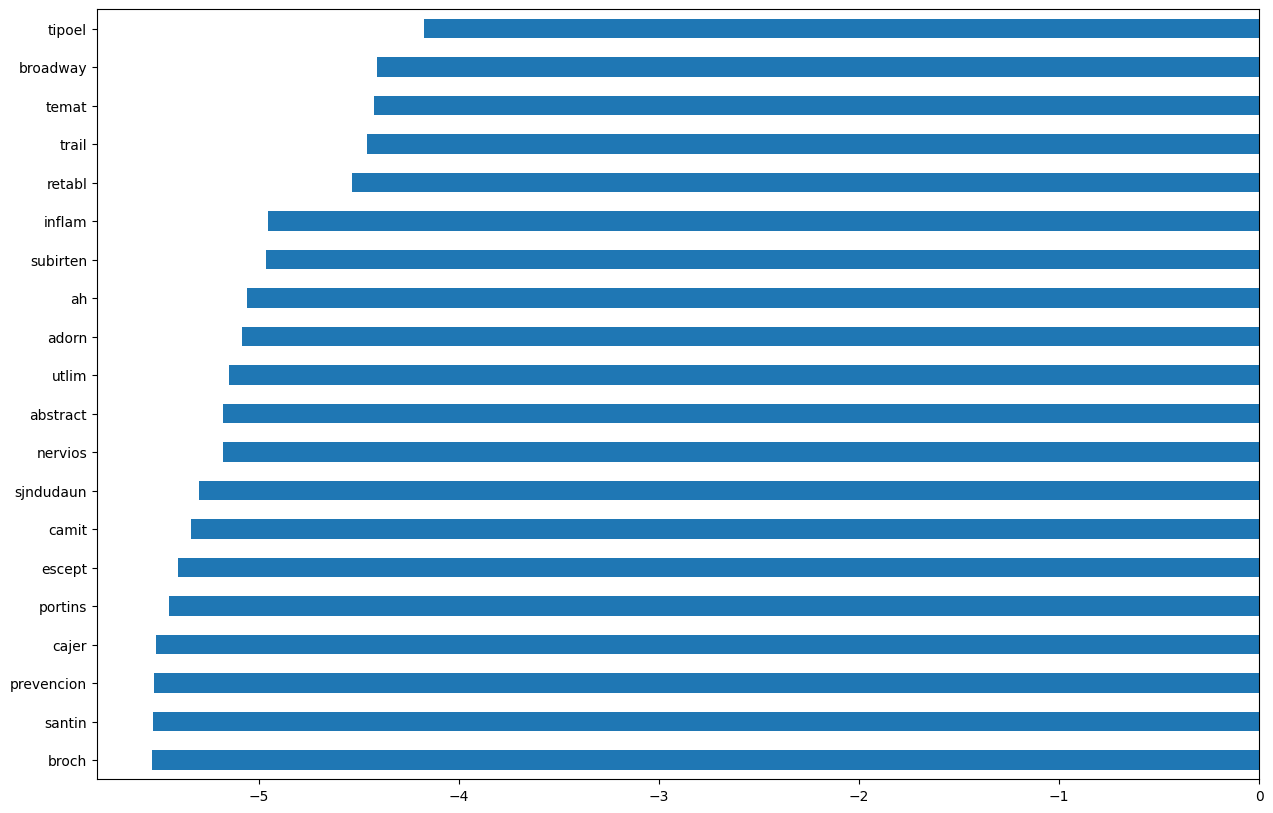

In [134]:
pd.Series(naive_bayes.feature_log_prob_[1], index = bow_vectorizer.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [135]:
y_train_naive_predict = naive_bayes.predict(X_train_bow)
y_test_naive_predict = naive_bayes.predict(bow_vectorizer.transform(X_test))

In [136]:
print('Clases', len(naive_bayes.classes_))
print('Etiquetas:', naive_bayes.classes_)
print('Features:', len(naive_bayes.feature_log_prob_[0]))
print('Features relevantes', np.count_nonzero(naive_bayes.feature_log_prob_))
print('Prior probabilities:', naive_bayes.class_log_prior_)
print('Feature log probabilities:', naive_bayes.feature_log_prob_)

Clases 5
Etiquetas: [1 2 3 4 5]
Features: 12574
Features relevantes 62870
Prior probabilities: [-2.29202226 -1.90606996 -1.61439341 -1.38008883 -1.20494972]
Feature log probabilities: [[ -6.04521361 -10.55607312 -10.55607312 ...  -9.86292594  -9.16977876
  -10.55607312]
 [ -6.20105878 -10.87388761 -10.87388761 ... -10.18074043  -8.79444607
   -9.77527532]
 [ -6.35121495 -10.32150686 -11.01465404 ... -11.01465404  -9.62835968
  -11.01465404]
 [ -6.78749559 -11.05017546 -11.05017546 ... -11.05017546  -9.6638811
  -11.05017546]
 [ -7.31308401  -9.99866136 -10.40412647 ... -11.09727365  -9.48783574
  -10.40412647]]


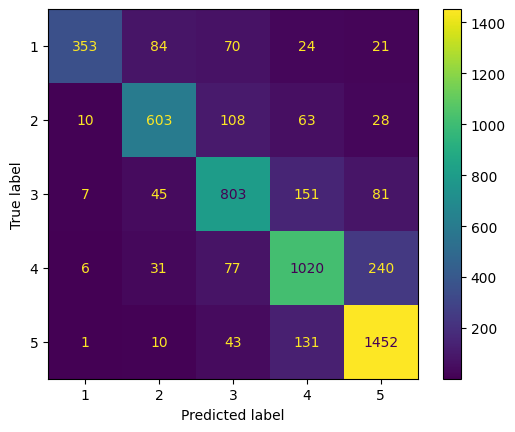

In [137]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_naive_predict)

In [138]:
print("accuracy:", naive_bayes.score(tfidf_vectorizer.transform(X_train), y_train))
print("precision:", precision_score(y_train, y_train_naive_predict, average='macro'))
print("recall:", recall_score(y_train, y_train_naive_predict, average='macro'))
print("f1:", f1_score(y_train, y_train_naive_predict, average='macro'))

accuracy: 0.8030025631636764
precision: 0.7954043631499406
recall: 0.7500361027697532
f1: 0.7665441574134453


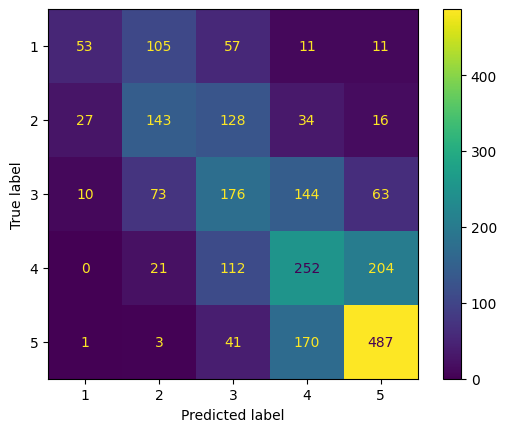

In [139]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_naive_predict)

In [140]:
print("accuracy:", naive_bayes.score(tfidf_vectorizer.transform(X_test), y_test))
print("precision:", precision_score(y_test, y_test_naive_predict, average='macro'))
print("recall:", recall_score(y_test, y_test_naive_predict, average='macro'))
print("f1:", f1_score(y_test, y_test_naive_predict, average='macro'))

accuracy: 0.4645602049530316
precision: 0.4750641903319436
recall: 0.426761326486941
f1: 0.43436592433024934


### Conclusiones

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## Selección de final